In [1]:
m_name = 'resnet34'
id_name = 'svhn'
optim_type = "SGD"
use_dataparallel = False

In [ ]:
from models.densenet import DenseNet3
import os 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
# from models.resnet_aman import ResNet34, ResNet18, ResNet50
from models.resnet_soyeong import ResNet34, ResNet18, ResNet50
import torch
from collections import OrderedDict
from torchvision.transforms import transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
from torch.autograd import Variable
from torch.utils.data import DataLoader, Subset, TensorDataset, RandomSampler
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
import numpy as np
import random
from time import time
# from joblib import load ,dump
import io,pickle
device = "cuda:0"
input_size = (32, 32) 
if id_name == 'cifar10' or id_name == 'svhn' or id_name == 'mnist' or id_name == 'fmnist' or id_name == 'kmnist' or id_name == 'qmnist' :
    num_classes =10 
    if m_name == 'densenet3':
        model = DenseNet3(100,num_classes).to(device)
    elif m_name == 'resnet18':
        model = ResNet18(num_classes).to(device)                                                                                                               
    elif m_name == 'resnet34':
        model = ResNet34(num_classes).to(device)
    elif m_name == 'resnet50':
        model = ResNet50(num_classes).to(device)
elif id_name == 'cifar100':
    num_classes = 100
    if m_name == 'densenet3':
        model = DenseNet3(100,num_classes).to(device)
    elif m_name == 'resnet18':
        model = ResNet18(num_classes).to(device)
    elif m_name == 'resnet34':
        model = ResNet34(num_classes).to(device)
    elif m_name == 'resnet50':
        model = ResNet50(num_classes).to(device)
else :
    print("----------------wrong params--------------------------")
    exit
 
model_path = f'./pre_trained/{optim_type}/{m_name}_{id_name}/{m_name}_{id_name}.pth'

model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)
model.eval()
# Wrap the model with DataParallel
if torch.cuda.device_count() > 1 and use_dataparallel == True:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# print(model)
"""
ID data -> Cifar 10
Profiling(mean and covariance is done on Cifar 10)
"""
data_path = "./data"
batch_size = 512
batch_size_adv = 512
data_root='./data' 
# Transformations for Id dataset (training dataset)
if id_name == 'svhn':
    input_size = (32, 32) 
    transform_id = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Common for SVHN
    ])
elif id_name == 'cifar10':
    input_size = (32, 32) 
    transform_id  = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor(),   
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))   
    ])
elif id_name in [ 'mnist','fmnist','kmnist','qmnist']:
    input_size = (32, 32) 
    transform_id=  transforms.Compose([
        transforms.Resize(input_size), 
        transforms.Grayscale(num_output_channels=3), 
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])
elif id_name == 'cifar100':
    input_size = (32, 32) 
    transform_id  = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor(),   
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))   
    ])
 

#tranformations for OOD and ADV samples:
# Transformations for Id dataset (training dataset)
if id_name == 'svhn':
    input_size = (32, 32) 
    transform_rgb = transform_id
    transform_bw =  transforms.Compose([
        transforms.Resize(input_size), 
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Common for SVHN
    ])
elif id_name == 'cifar10':
    input_size = (32, 32) 
    transform_rgb = transform_id
    transform_bw  = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),   
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))   
    ])
elif id_name in [ 'mnist','fmnist','kmnist','qmnist']:
    input_size = (32, 32) 
    transform_rgb = transform_id
    transform_bw=  transforms.Compose([
        transforms.Resize(input_size), 
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
elif id_name == 'cifar100':
    input_size = (32, 32) 
    transform_rgb = transform_id
    transform_bw  = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),   
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))   
    ])


datasets = {
    'cifar10' : (datasets.CIFAR10(root=data_root,train=True, download=True, transform=transform_id),
                 datasets.CIFAR10(root=data_root,train=False, download=True, transform=transform_id)),
    'cifar100' : (datasets.CIFAR100(root=data_root,train=True, download=True, transform=transform_id),
                 datasets.CIFAR100(root=data_root,train=False, download=True, transform=transform_id)),
    'mnist': (datasets.MNIST(root=data_root, train=True, download=True, transform=transform_id),
                datasets.MNIST(root=data_root, train=False, download=True, transform=transform_id)),
    'qmnist': (datasets.QMNIST(root=data_root, train=True, download=True, transform=transform_id),
                datasets.QMNIST(root=data_root, train=False, download=True, transform=transform_id)),
    'kmnist': (datasets.KMNIST(root=data_root, train=True, download=True, transform=transform_id),
                datasets.KMNIST(root=data_root, train=False, download=True, transform=transform_id)),
    'fmnist': (datasets.FashionMNIST(root=data_root, train=True, download=True, transform=transform_id),
                datasets.FashionMNIST(root=data_root, train=False, download=True, transform=transform_id)),
    'svhn' : (datasets.SVHN(root=data_path, split='train', download=True, transform=transform_id),
              datasets.SVHN(root=data_path, split='test', download=True, transform=transform_id))
              
}   
train_dataset, test_dataset = datasets[id_name]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)

# Set a fixed random seed for reproducibility across all datasets
seed = 42
torch.manual_seed(seed)  # You can change this to any integer value

# Number of samples to select from each dataset
num_samples = 2000

# Function to create a subset of 2000 random samples from a dataset
def get_random_subset(dataset, num_samples, seed=42):
    # Ensure the random seed is set for reproducibility
    generator = torch.Generator().manual_seed(seed)
    # If dataset is smaller than num_samples, use the full dataset
    dataset_size = len(dataset)
    sample_size = min(num_samples, dataset_size)
    # Create random indices using RandomSampler
    sampler = RandomSampler(dataset, num_samples=sample_size, generator=generator)
    indices = list(sampler)
    # Create a Subset with the selected indices
    return Subset(dataset, indices)


# KMNIST
kmnist_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform_bw)
kmnist_subset = get_random_subset(kmnist_dataset, num_samples, seed=seed)
kmnist_test_loader = DataLoader(kmnist_subset, batch_size=batch_size, shuffle=False)

# MNIST
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_bw)
mnist_subset = get_random_subset(mnist_dataset, num_samples, seed=seed)
mnist_test_loader = DataLoader(mnist_subset, batch_size=batch_size, shuffle=False)

# QMNIST
qmnist_dataset = torchvision.datasets.QMNIST(root='./data', train=False, download=True, transform=transform_bw)
qmnist_subset = get_random_subset(qmnist_dataset, num_samples, seed=seed)
qmnist_test_loader = DataLoader(qmnist_subset, batch_size=batch_size, shuffle=False)

# FashionMNIST (FMNIST)
fmnist_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_bw)
fmnist_subset = get_random_subset(fmnist_dataset, num_samples, seed=seed)
fmnist_test_loader = DataLoader(fmnist_subset, batch_size=batch_size, shuffle=False)

sun397_dataset = torchvision.datasets.SUN397(root='./data', download=True, transform=transform_rgb)
sun397_subset = get_random_subset(sun397_dataset, num_samples, seed = seed)
sun397_test_loader = DataLoader(sun397_subset, batch_size=batch_size, shuffle=False)

gtsrb_dataset = torchvision.datasets.GTSRB(root='./data', split='test', download=True, transform=transform_rgb)
gtsrb_subset = get_random_subset(gtsrb_dataset, num_samples, seed = seed)
gtsrb_test_loader = DataLoader(gtsrb_subset, batch_size=batch_size, shuffle=False)

celebA_dataset = torchvision.datasets.CelebA(root='./data', split='test', download=True, transform=transform_rgb)
celebA_subset = get_random_subset(celebA_dataset, num_samples, seed = seed)
celebA_test_loader = DataLoader(celebA_subset, batch_size=batch_size, shuffle=False)

imagenette_dataset = torchvision.datasets.Imagenette(root='./data', split='val', download=True, transform=transform_rgb)
imagenette_subset = get_random_subset(imagenette_dataset, num_samples, seed = seed)
imagenette_test_loader = DataLoader(imagenette_subset, batch_size=batch_size, shuffle=False)

pcam_dataset = torchvision.datasets.PCAM(root='./data', split='test', download=True, transform=transform_rgb)
pcam_subset = get_random_subset(pcam_dataset, num_samples, seed = seed)
pcam_test_loader = DataLoader(pcam_subset, batch_size=batch_size, shuffle=False)

renderedsst2_dataset = torchvision.datasets.RenderedSST2(root='./data', split='test', download=True, transform=transform_rgb)
renderedsst2_subset = get_random_subset(renderedsst2_dataset, num_samples, seed = seed)
renderedsst2_test_loader = DataLoader(renderedsst2_subset, batch_size=batch_size, shuffle=False)

fake_dataset = torchvision.datasets.FakeData(size=num_samples, image_size=(3, 32, 32), transform=transform_rgb)
fake_test_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False)  # Already 2000 samples, no subset needed

eurosat_dataset = torchvision.datasets.EuroSAT(root='./data', download=True, transform=transform_rgb)
eurosat_subset = get_random_subset(eurosat_dataset, num_samples, seed = seed)
eurosat_loader = DataLoader(eurosat_subset, batch_size=batch_size, shuffle=False)

svhn_test_dataset = torchvision.datasets.SVHN(root=data_path, split='test', download=True, transform=transform_rgb)
svhn_subset = get_random_subset(svhn_test_dataset, num_samples, seed = seed)
svhn_test_loader = DataLoader(svhn_subset, batch_size=batch_size, shuffle=False)

# isun_test_dataset = torchvision.datasets.ImageFolder(root=f"{data_path}/isun", transform=transform_rgb)
# isun_subset = get_random_subset(isun_test_dataset, num_samples, seed = seed)
# isun_test_loader = DataLoader(isun_subset, batch_size=batch_size, shuffle=False)

# lsun_test_dataset = torchvision.datasets.ImageFolder(root=f"{data_path}/lsun_resize", transform=transform_rgb)
# lsun_subset = get_random_subset(lsun_test_dataset, num_samples, seed = seed)
# lsun_test_loader = DataLoader(lsun_subset, batch_size=batch_size, shuffle=False)

cifar100_test_dataset = torchvision.datasets.CIFAR100(root=data_path, train=False, download=True, transform=transform_rgb)
cifar100_subset = get_random_subset(cifar100_test_dataset, num_samples, seed = seed)
cifar100_test_loader = DataLoader(cifar100_subset, batch_size=batch_size, shuffle=False)

dtd_test_dataset = torchvision.datasets.DTD(root="./data", split="test", download=True, transform=transform_rgb)
dtd_subset = get_random_subset(dtd_test_dataset, num_samples, seed = seed)
dtd_test_loader = DataLoader(dtd_subset, batch_size=batch_size, shuffle=False)

# tiny_imagenet_dataset = torchvision.datasets.ImageFolder(root=f"{data_path}/tiny-imagenet/tiny-imagenet-200/val", transform=transform_rgb)
# tiny_imagenet_subset = get_random_subset(tiny_imagenet_dataset, num_samples, seed = seed)
# tiny_imagenet_loader = DataLoader(tiny_imagenet_subset, batch_size=batch_size, shuffle=False)

places365_test_dataset = torchvision.datasets.Places365(root="./data", split="val", small=True, download=True, transform=transform_rgb)
places365_subset = get_random_subset(places365_test_dataset, num_samples, seed = seed)
places365_test_loader = DataLoader(places365_subset, batch_size=batch_size, shuffle=False)

inaturalist_dataset = torchvision.datasets.INaturalist(root='./data', version='2021_valid', transform=transform_rgb, download=True)
inaturalist_subset = get_random_subset(inaturalist_dataset, num_samples, seed = seed)
inaturalist_loader = DataLoader(inaturalist_subset, batch_size=batch_size, shuffle=False)

# Adversarial datasets (AutoAttack, FGSM, PGD, CW, DeepFool)
def create_adversarial_loader(file_path, num_samples, batch_size, seed=42):
    data = torch.load(file_path, weights_only=False)
    data_list, label_list = zip(*data)
    inputs_tensor = torch.stack([torch.from_numpy(data).float() for data in data_list])
    labels_tensor = torch.tensor(label_list, dtype=torch.long)
    dataset = TensorDataset(inputs_tensor, labels_tensor)
    subset = get_random_subset(dataset, num_samples, seed)
    return DataLoader(subset, batch_size=batch_size, shuffle=False)

# autoattack_test_loader = create_adversarial_loader(f'./adv_samples/{m_name}_{id_name}_autoattack.pt', num_samples, batch_size, seed = seed)
fgsm_test_loader = create_adversarial_loader(f'./adv_samples/{m_name}_{id_name}_fgsm.pt', num_samples, batch_size, seed = seed)
pgd_test_loader = create_adversarial_loader(f'./adv_samples/{m_name}_{id_name}_pgd.pt', num_samples, batch_size, seed = seed)
cw_test_loader = create_adversarial_loader(f'./adv_samples/{m_name}_{id_name}_cw.pt', num_samples, batch_size, seed = seed)
deepfool_test_loader = create_adversarial_loader(f'./adv_samples/{m_name}_{id_name}_deepfool.pt', num_samples, batch_size, seed = seed)
# autoAttack_data = torch.load(f'./adv_samples/{m_name}_{id_name}_autoattack.pt',weights_only= False)
 
# data_list, label_list = zip(*autoAttack_data)
# inputs_tensor = torch.stack([torch.from_numpy(data).float() for data in data_list])
# labels_tensor = torch.tensor(label_list, dtype=torch.long)

# AA_dataset = TensorDataset(inputs_tensor, labels_tensor)
# Autoattack_test_loader = DataLoader(AA_dataset, batch_size=batch_size, shuffle=False)

# fgsm_data = torch.load(f'./adv_samples/{m_name}_{id_name}_fgsm.pt',weights_only= False)
# data_list, label_list = zip(*fgsm_data)
# inputs_tensor = torch.stack([torch.from_numpy(data).float() for data in data_list])
# labels_tensor = torch.tensor(label_list, dtype=torch.long)
# fsgm_dataset = TensorDataset(inputs_tensor, labels_tensor)
# fgsm_test_loader = DataLoader(fsgm_dataset, batch_size=batch_size, shuffle=False)

# pgd_data = torch.load(f'./adv_samples/{m_name}_{id_name}_pgd.pt',weights_only= False)
# data_list, label_list = zip(*pgd_data)
# inputs_tensor = torch.stack([torch.from_numpy(data).float() for data in data_list])
# labels_tensor = torch.tensor(label_list, dtype=torch.long)
# pgd_dataset = TensorDataset(inputs_tensor, labels_tensor)
# pgd_test_loader = DataLoader(pgd_dataset, batch_size=batch_size, shuffle=False)

# cw_data = torch.load(f'./adv_samples/{m_name}_{id_name}_cw.pt',weights_only= False)
# data_list, label_list = zip(*cw_data)
# inputs_tensor = torch.stack([torch.from_numpy(data).float() for data in data_list])
# labels_tensor = torch.tensor(label_list, dtype=torch.long)
# cw_dataset = TensorDataset(inputs_tensor, labels_tensor)
# cw_test_loader = DataLoader(cw_dataset, batch_size=batch_size, shuffle=False)

# deepfool_data = torch.load(f'./adv_samples/{m_name}_{id_name}_deepfool.pt',weights_only= False)
# data_list, label_list = zip(*deepfool_data)
# inputs_tensor = torch.stack([torch.from_numpy(data).float() for data in data_list])
# labels_tensor = torch.tensor(label_list, dtype=torch.long)
# deepfool_dataset = TensorDataset(inputs_tensor, labels_tensor)
# deepfool_test_loader = DataLoader(deepfool_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Files already downloaded and verified


  1%|▏         | 9.14M/625M [01:16<1:17:00, 133kB/s] 

In [ ]:
import time
measure_time =  False
output_file = "./results/Adam/Trishul_experiments.txt"
# Ensure output directory exists
os.makedirs(f"./results/Trishul_Experiments", exist_ok=True)
loaders = {
    "pgd": pgd_test_loader,
    "fgsm": fgsm_test_loader,
    # "aa": autoattack_test_loader,
    # "deepfool": deepfool_test_loader,
    # # "cw" : cw_test_loader,
    "ID_test": test_loader,
    "ID_train": train_loader,
}
def test_accuracy(model,loaders):
    model.eval()  # Set model to evaluation mode
    if measure_time == False:
        header = f"{'Dataset':<15} | {'Accuracy (%)':<12}"  # Left-aligned columns
        separator = "-" * len(header)

    model.eval()
    with torch.no_grad(): 
        
        with open(output_file, 'a') as file :
            if measure_time == False:
                file.write(f"\nTesting the accuracy of model ({m_name}) trained on {id_name}\n\n")
                file.write(header + "\n")
                file.write(separator + "\n")
                print(f" Accuracy of ADV and ID of {m_name} trained on {id_name} ")
                print(header)
                print(separator)
            start_time= time.time()
            
           
            for item in loaders:
                temp_loader = loaders[item]  
                correct = 0
                total = 0
                for inputs, labels in temp_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, dim=1)  
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                accuracy = correct / total
                print(f"{item:<15} | {accuracy*100:<12}")
                if measure_time == False:
                    file.write(f"{item:<15} | {accuracy*100:<12}\n")
            end_time = time.time() 
            file.write(f" \n total timn ={end_time -start_time} ")
            # file2.write(f" \n total timn ={end_time -start_time} ")
test_accuracy(model,loaders)
 

 Accuracy of ADV and ID of resnet50 trained on svhn 
Dataset         | Accuracy (%)
------------------------------
ID_test         | 96.25460971112477
ID_train        | 96.65697476009119


## find  Centriod ! ( Find the center of all the clusters.(useful for 1))

In [ ]:
import time
start_time = time.time()

import torch
 
import cupy as cp
cp.cuda.Device(1).use()
 
flag = 0
batch_count = 0

labels = []

layer_index = -1
model.eval()
train_dataset, test_dataset = datasets[id_name]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)
loaders = train_loader

with torch.no_grad():
    rolling_sum = {}
    rolling_mean = {}
    distances  = {}
    for inputs, targets in loaders:
        inputs = inputs.to(device)

        feats= model.intermediate_forward_all(inputs)
        """ 
          return out,out1,out2,out3,out4,conv_feats,logits
          this is return from intermediate_forward_all.

          use only out,...out4 for  mahalanobis calculations

        
        """
        conv_feats = feats[-2]  # only conv_feats
        feats = feats[:-2]   # out,out1,out2,out3,out4,
        num_layers_maha = len(feats)

        num_layers = len(conv_feats)
        # print(num_layers)
        i = 0
        flag = {}
        
        batch_count += feats[0].shape[0]
        # print(batch_count," batch count ")
        for f in conv_feats:
           
            f=f.view(f.size(0),-1)
            if i not in flag:
           
                rolling_sum[i] =  cp.zeros((1, f.shape[1]))
                distances[i] = []
            
            
            f=cp.asarray(f)
            rolling_sum[i] += cp.sum(f,axis=0)
            if i not in flag:
                flag[i] = 0
                i += 1 
        labels.extend(targets.cpu().numpy())   
    
    for j in range(i):
        rolling_mean[j] = rolling_sum[j] / batch_count
 

print(len(rolling_mean))

end_time = time.time()
print(end_time-start_time)
num_layers = len(rolling_mean)

100
22.880249977111816


# Distance from origin and centroid for datasets 

In [ ]:

loaders = {
    "mnist" : mnist_test_loader,
    "kmnist" : kmnist_test_loader,
    "qmnist" : qmnist_test_loader,
    "fmnist" : fmnist_test_loader,
    "cifar100": cifar100_test_loader,
    "cifar10": cifar100_test_loader,
    "pgd": pgd_test_loader,
    "fgsm": fgsm_test_loader,
    "aa": autoattack_test_loader,
    "deepfool": deepfool_test_loader,
    # "cw" : cw_test_loader,
    "isun": isun_test_loader,
    "lsun":lsun_test_loader,
    "svhn": svhn_test_loader,
    'eurosat': eurosat_loader,
    'pcam' : pcam_test_loader,
    "renderedsst2" : renderedsst2_test_loader,
    "dtd": dtd_test_loader,
    "ID_test": test_loader,
    "ID_train": train_loader,
    'places365' : places365_test_loader,
} 
centroid_distances = {}
origin_distances = {}
centroid_distances_csv = f'./results/Adam/Cent_Org_Dist_{m_name}_{id_name}.csv'
import csv 
with open(centroid_distances_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["DataType","True label"] + [f"Radial_{k}" for k in range(num_layers)] +  [f"Origin_{k}" for k in range(num_layers)] )
    with torch.no_grad():
        # temp_time = time.time()
        # print(time.time()- start_time," .... starting now")
        for item in loaders:
            loader = loaders[item]   
            print(item)       
            labels = []
            for i in range(num_layers):
                centroid_distances[i] = []
            for i in range(num_layers_maha):
                origin_distances[i] = []
 
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                feats= model.intermediate_forward_all(inputs)
 
                logits = feats[-1]
                maha_feats= feats[:-2]
                conv_feats= feats[-2]
                logits  =  F.softmax(logits/1000, dim= 1).max(dim=1)[0]
                logits = logits.cpu().tolist()
 
                for i,f in enumerate(conv_feats):
                    f=f.view(f.size(0),-1)
                    f=cp.asarray(f)
                    centroid_distances[i] = cp.linalg.norm(f - rolling_mean[i],axis=1,ord = 2).tolist()
                    origin_distances[i] = cp.linalg.norm(f,axis=1,ord = 2).tolist()
                labels = list(targets)   
                for i in range(len(centroid_distances[0])):
                    dtype = item
                    row = [dtype, labels[i].item()]
                    row += [f"{centroid_distances[j][i] }" for j in range(num_layers)]
                    row += [f"{origin_distances[j][i]:.4f}" for j in range(num_layers)]
                    # print(row)
                    writer.writerow(row)
            # print("Done ")   
 
        end_time = time.time()
   
 

 

NameError: name 'num_layers' is not defined

## Plot the mean distance layerwise from centroid.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v2 as imageio
import glob
import os

# Define your custom categories
def classify_data_type(data_type, adv_list, ood_types):
    if data_type in ['ID_test', 'ID_train']:
        return 'ID'
    elif data_type in adv_list:
        return 'Adv'
    elif data_type in ood_types:
        return 'OOD'
    return 'Other'
 

# Define the list of layers
k_values = [k for k in range(num_layers)]
print(k_values)
# Define other constants
mnist_list = ["mnist","kmnist","qmnist","fmnist"]
adv_list = ['pgd','fgsm','aa','deepfool','cw']
ood_type_list = ['cifar10',"cifar100","isun", "lsun", "svhn", "dtd","eurosat", "pcam", "renderedsst2","mnist","kmnist","qmnist","fmnist"]  

if id_name == "cifar10" or id_name == "cifar100":
    ood_type_list.remove("cifar10")
    ood_type_list.remove("cifar100")
    ood_type_list.remove("dtd")
elif id_name in mnist_list:
    ood_type_list = [x for x in ood_type_list if x not in mnist_list]
print("--------------")
print(ood_type_list)
# Custom order for plotting
custom_order = ['ID_test','ID_train'] + adv_list + ood_type_list

# Load the DataFrame
df = pd.read_csv(centroid_distances_csv)



# Main loop for each layer
for k in k_values:
    radial_col = f"Radial_{k}"
    origin_col = f"Origin_{k}"

    # Check if columns exist
    if radial_col not in df.columns or origin_col not in df.columns:
        print(f"Skipping layer {k}: Columns {radial_col} or {origin_col} not found.")
        continue

    # Group by DataType
    mean_df = df.groupby('DataType')[[radial_col, origin_col]].mean().reset_index()
    mean_df['DataType'] = pd.Categorical(mean_df['DataType'], categories=custom_order, ordered=True)
    mean_df = mean_df.sort_values('DataType').reset_index(drop=True)
    
    # Classify data types
    mean_df['Category'] = mean_df['DataType'].apply(
        lambda x: classify_data_type(x, adv_list, ood_type_list)
    )
    
    # Plotting
    x = np.arange(len(mean_df))
    bar_width = 0.35
    
    # Category color mapping
    category_colors = {
        'ID': '#2196F3',    # Blue
        'Adv': '#F44336',   # Red
        'OOD': '#4CAF50'    # Green
    }
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot bars
    for i, (_, row) in enumerate(mean_df.iterrows()):
        if pd.isna(row['Category']):
            continue
        color = category_colors[row['Category']]
        ax.bar(x[i] - bar_width/2, row[radial_col], bar_width, 
               color=color, alpha=0.7, label=row['DataType'])
        ax.bar(x[i] + bar_width/2, row[origin_col], bar_width, 
               color=color, alpha=1.0)

    # Customize plot
    ax.set_title(f"Mean Distance from Centroid and Origin (Layer {k})\nModel: {m_name}, ID Dataset: {id_name}", fontsize=14)
    ax.set_xlabel("Data Type", fontsize=12)
    ax.set_ylabel("Mean Distance", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(mean_df['DataType'], rotation=45, ha='right')
    ax.grid(True, axis='y')
    
    # Create legends
    from matplotlib.patches import Patch
    
    # Distance type legend
    distance_legend_elements = [
        Patch(facecolor='gray', edgecolor='black', alpha=0.7, label='Radial Distance'),
        Patch(facecolor='gray', edgecolor='black', alpha=1.0, label='Origin Distance')
    ]
    ax.legend(handles=distance_legend_elements, title='Distance Type', loc='upper right')
    
    # Category legend
    category_legend_elements = [
        Patch(facecolor=category_colors['ID'], edgecolor='black', label='ID Data'),
        Patch(facecolor=category_colors['Adv'], edgecolor='black', label='Adversarial'),
        Patch(facecolor=category_colors['OOD'], edgecolor='black', label='OOD Data')
    ]
    ax.legend(handles=category_legend_elements, title='Categories', loc='upper left')
    
    plt.tight_layout()
    plot_file = f"./results/Trishul_Experiments/plot_{m_name}_{id_name}_layer{k}.png"
    plt.savefig(plot_file, dpi=300)
    plt.close()

# Create GIF from all saved plots
try:
    plot_files = sorted(glob.glob(f"./results/Trishul_Experiments/plot_{m_name}_{id_name}_layer*.png"))
    images = [imageio.imread(f) for f in plot_files]
    
    if images:  # Only create GIF if images exist
        imageio.mimsave(f"./results/{m_name}_{id_name}_summary.gif", images, duration=500, loop=0)
        print(f"GIF created successfully at ./results/{m_name}_{id_name}_summary.gif")
    else:
        print("No images found to create GIF")
        
except Exception as e:
    print(f"Error creating GIF: {e}")


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
--------------
['isun', 'lsun', 'svhn', 'eurosat', 'pcam', 'renderedsst2', 'mnist', 'kmnist', 'qmnist', 'fmnist']
GIF created successfully at ./results/densenet3_cifar100_summary.gif


## Plot the std of values classwise and layerwise. layerwise from centroid.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------
['isun', 'lsun', 'svhn', 'eurosat', 'pcam', 'renderedsst2', 'mnist', 'kmnist', 'qmnist', 'fmnist']


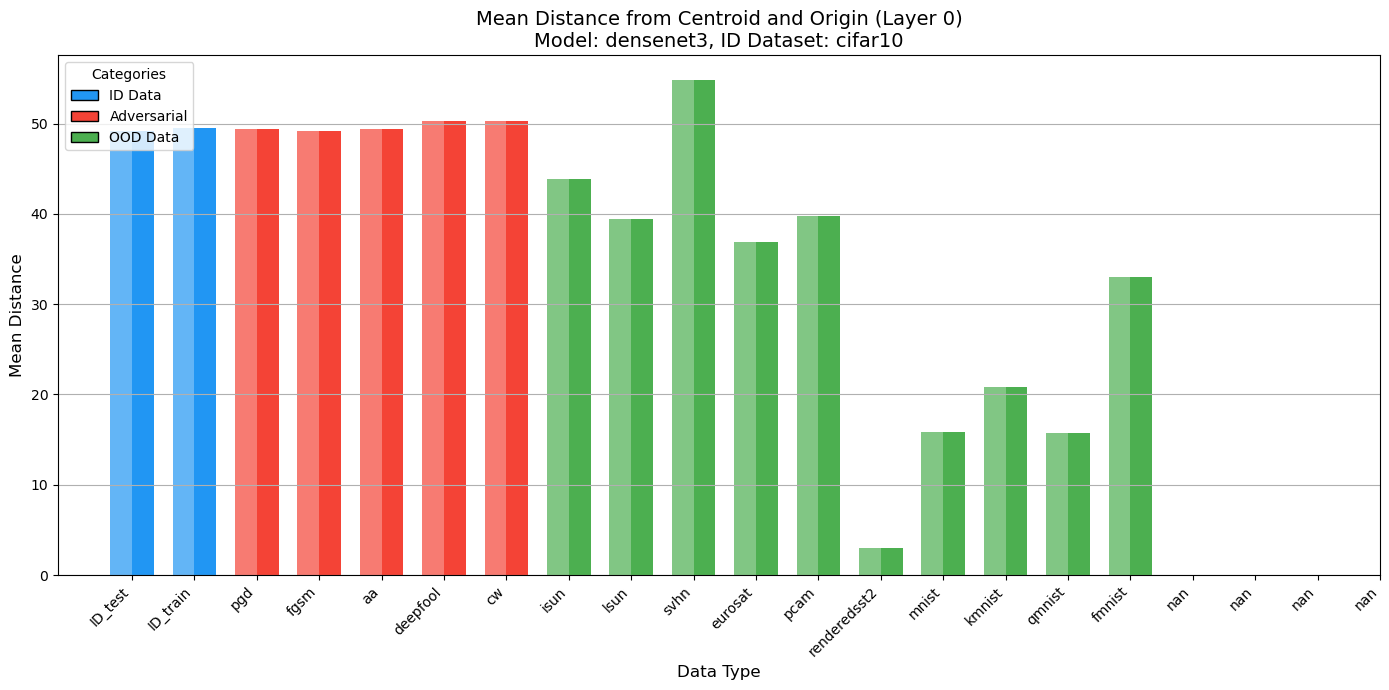

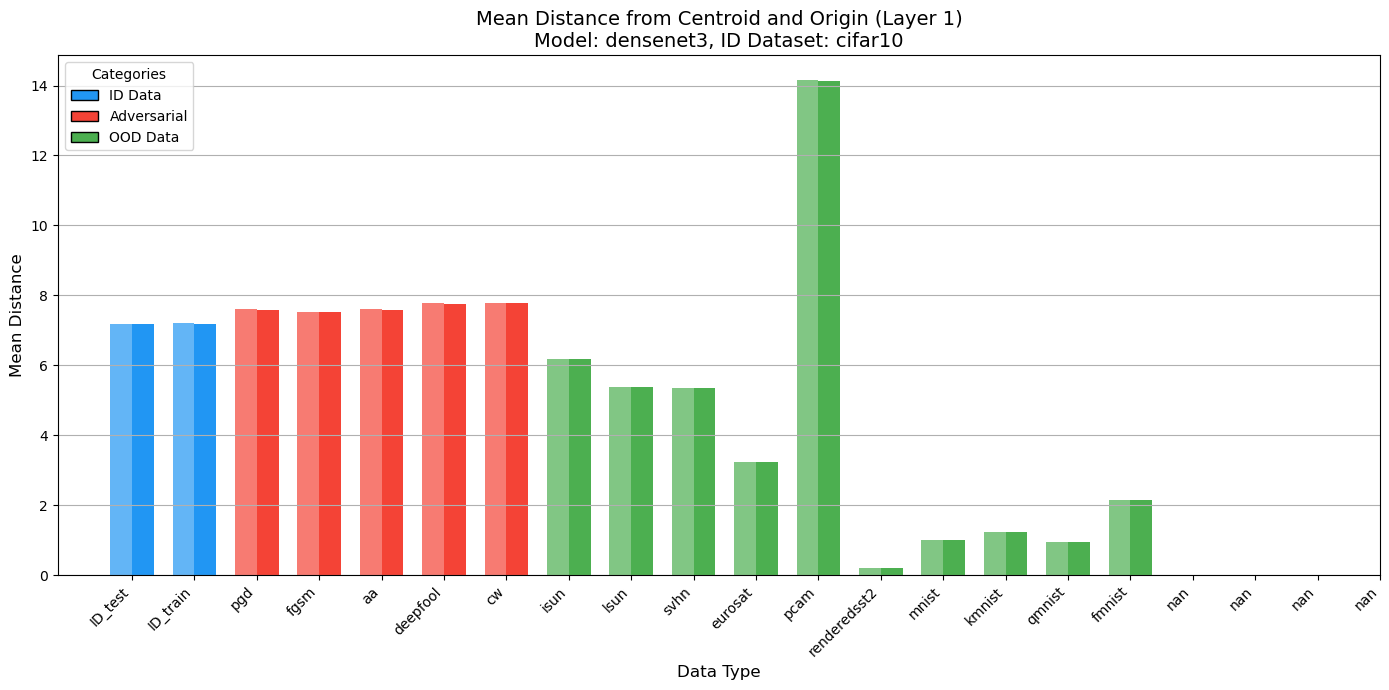

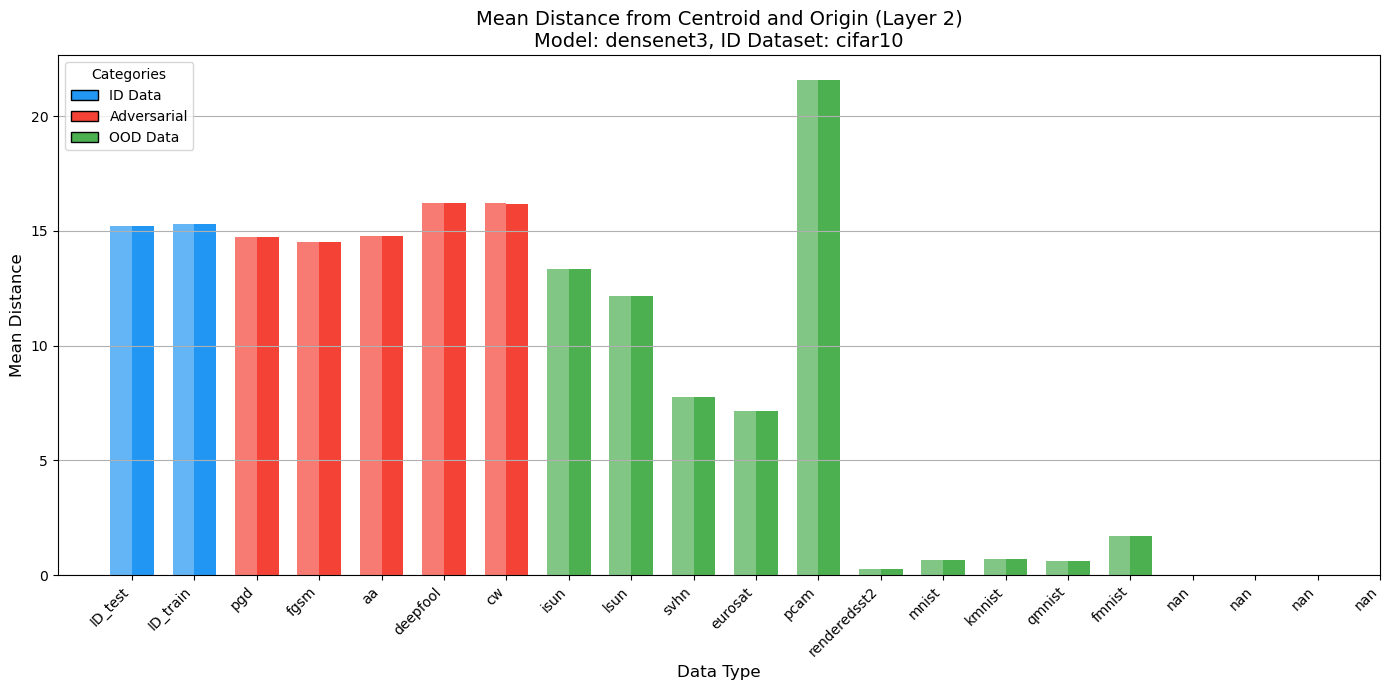

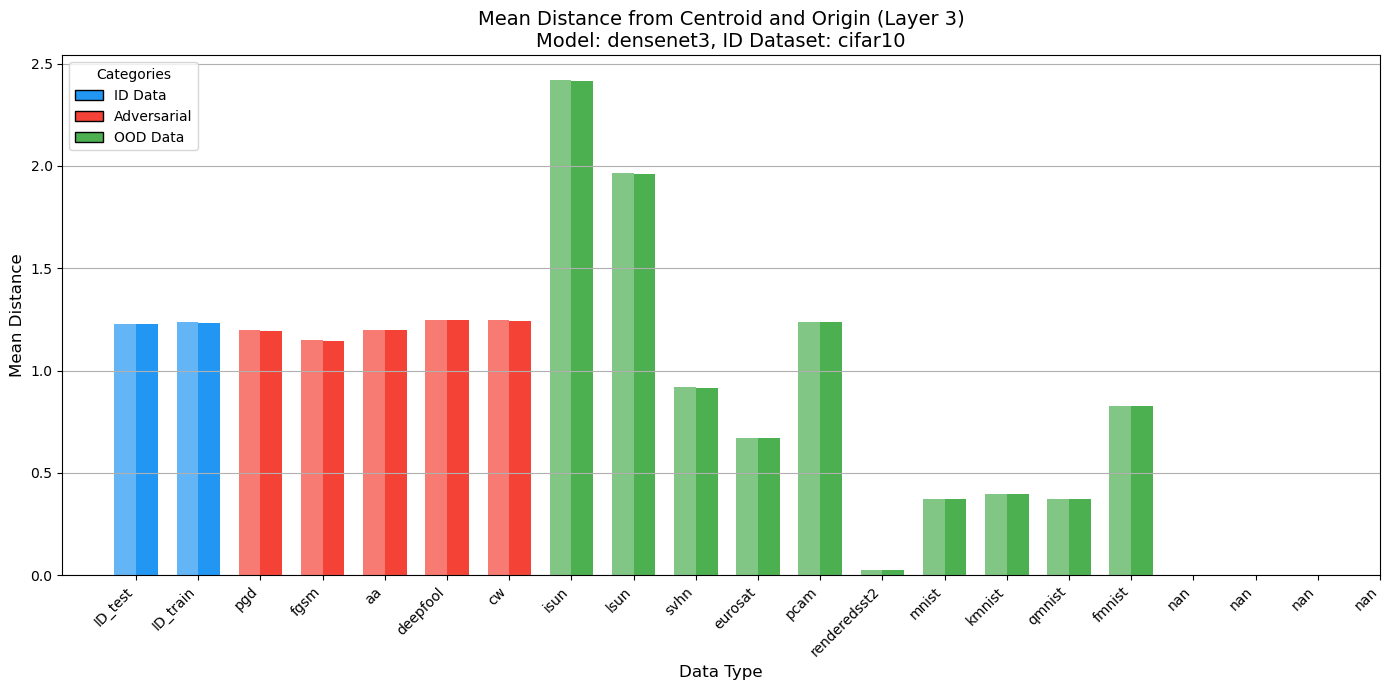

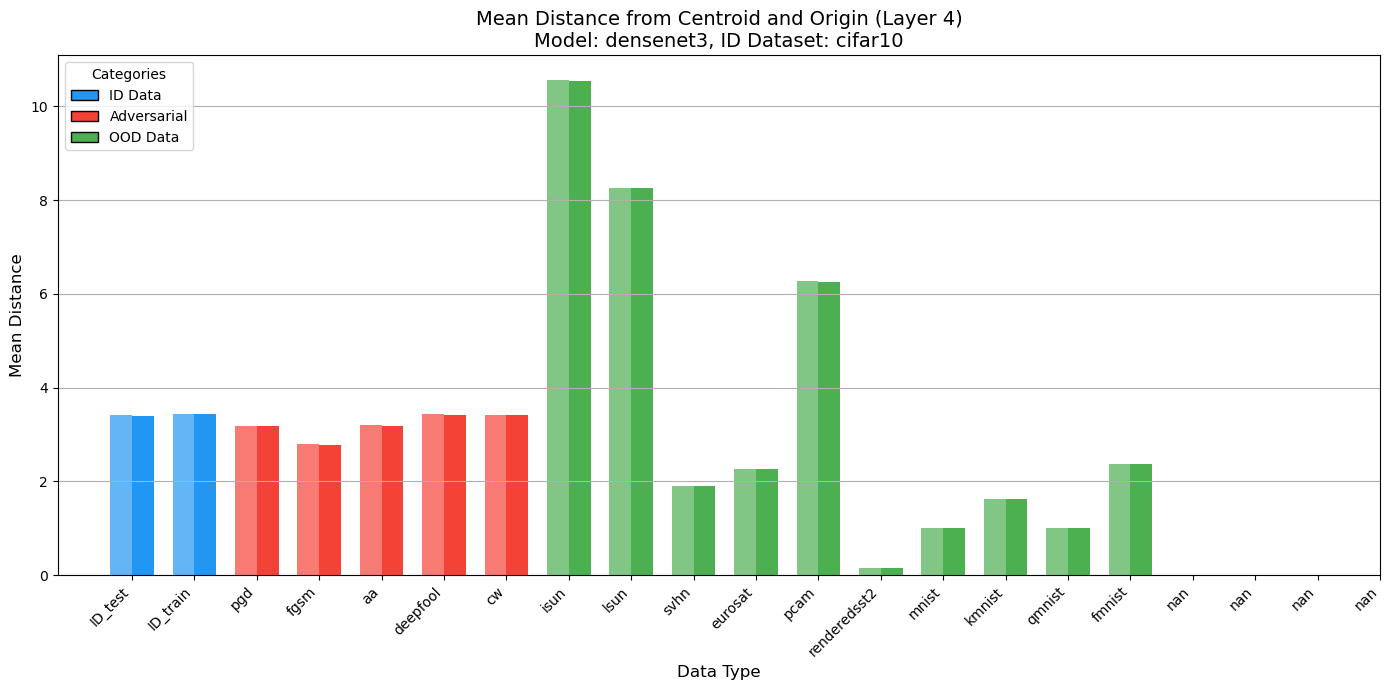

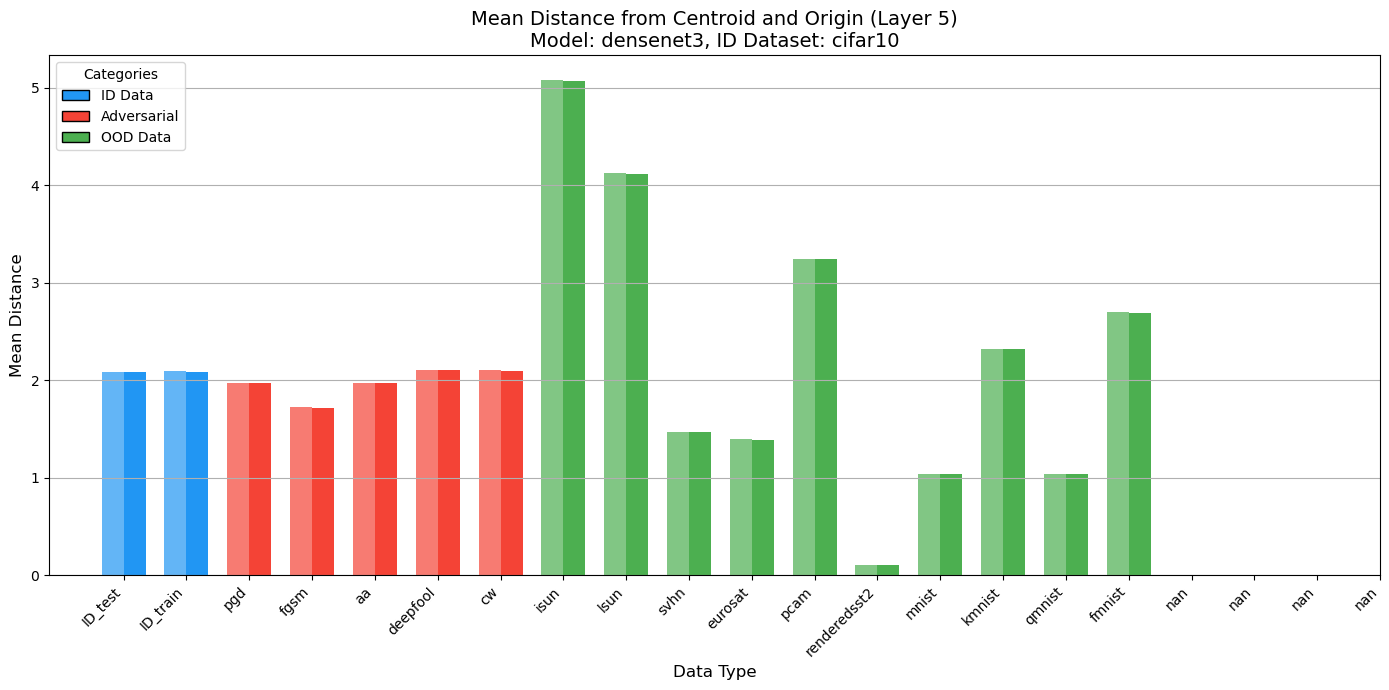

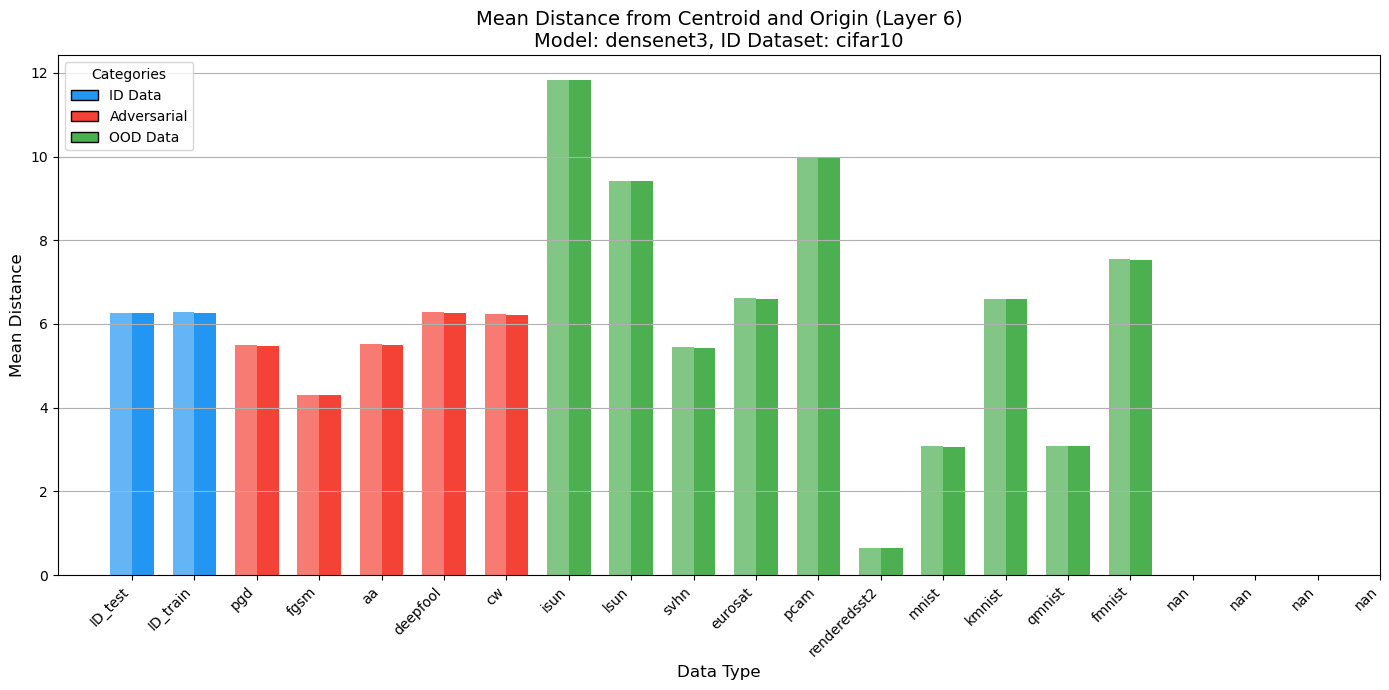

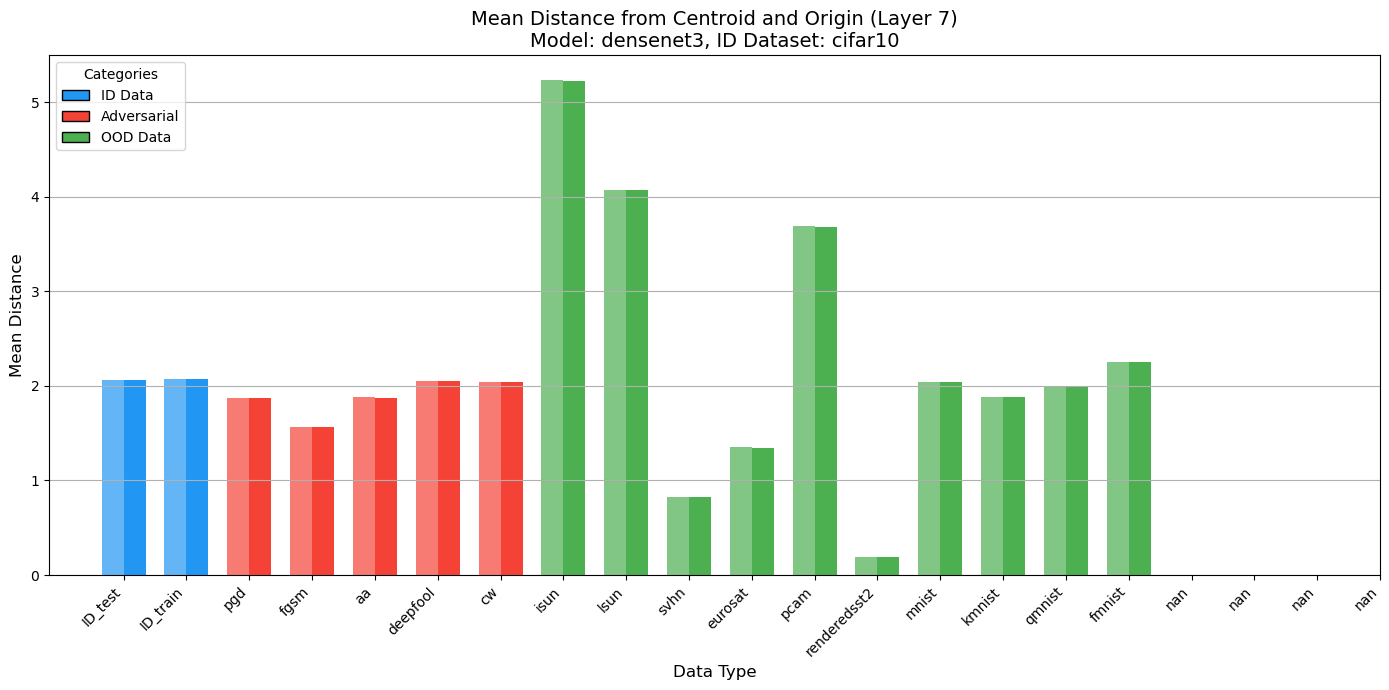

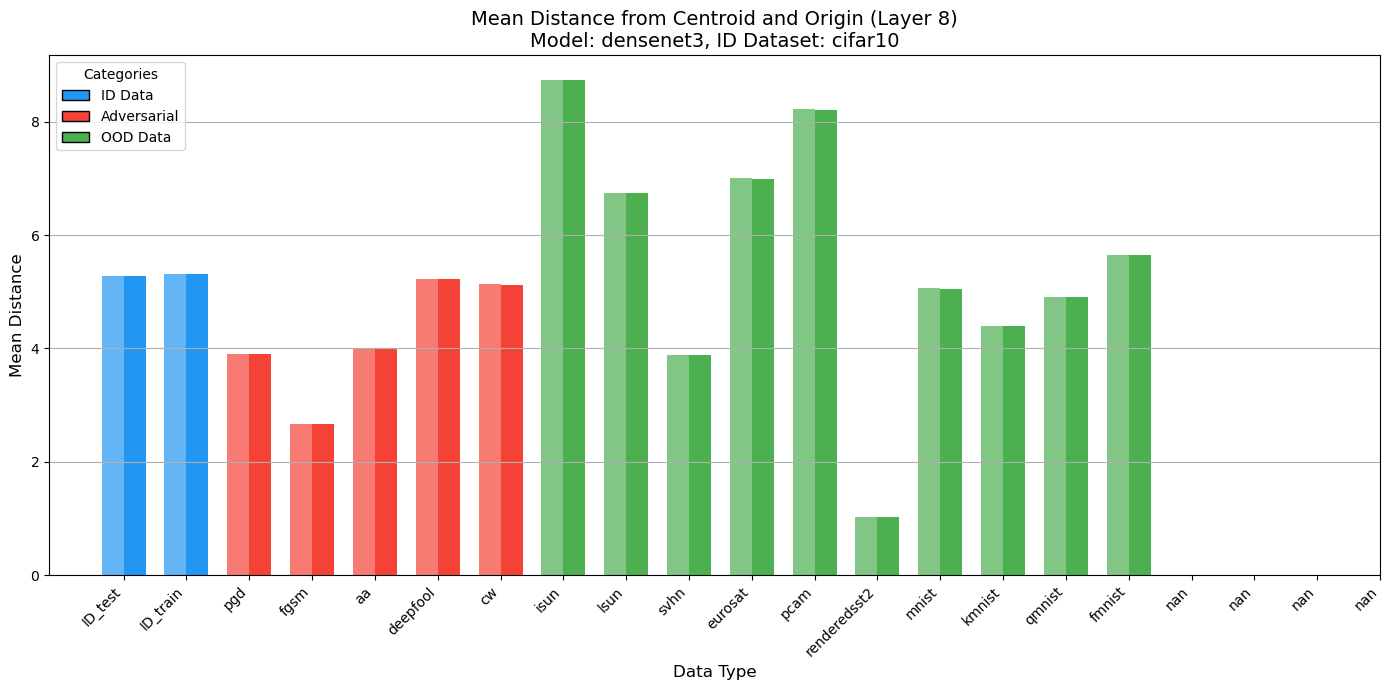

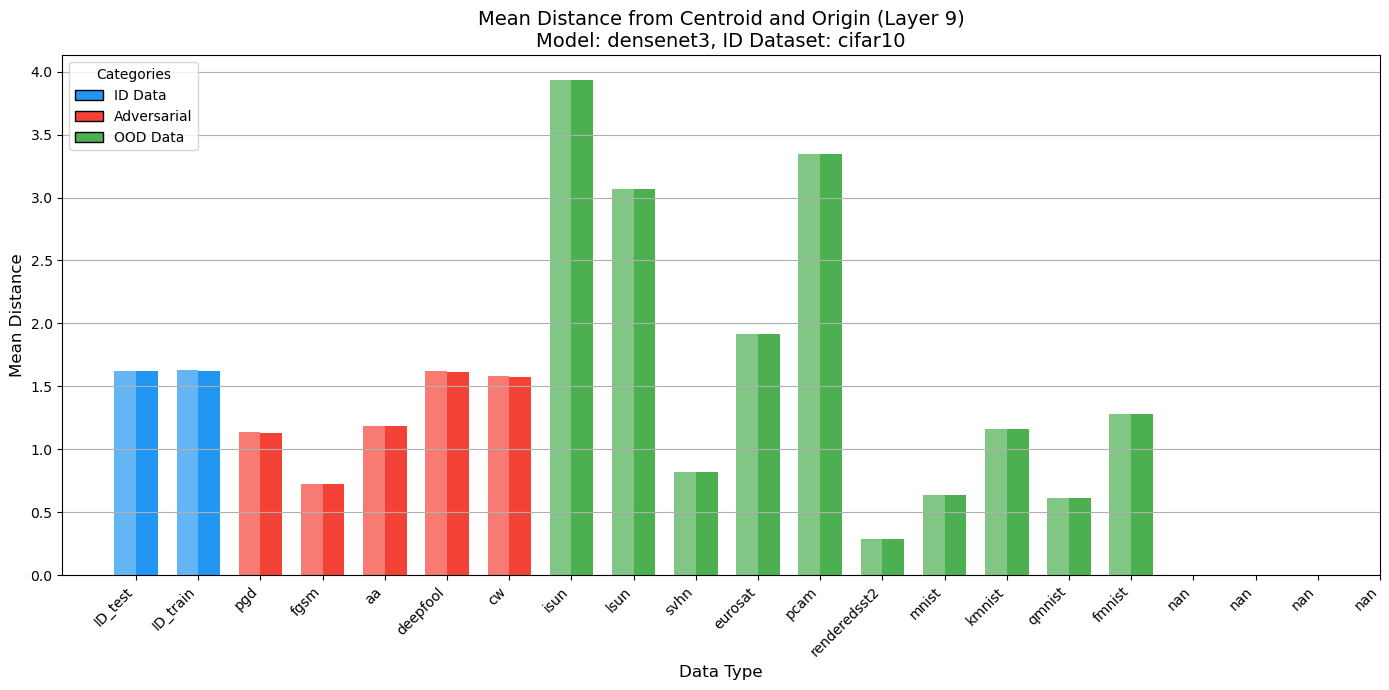

GIF created successfully at ./results/densenet3_cifar10_summary.gif


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import imageio.v2 as imageio
# import glob
# import os
# m_name = 'densenet3'
# id_name = 'cifar10'
# use_dataparallel = False
# num_layers =10
# centroid_distances_csv = f'./results/Adam/Cent_Org_Dist_{m_name}_{id_name}.csv'
# # Define your custom categories
# def classify_data_type(data_type, adv_list, ood_types):
#     if data_type in ['ID_test', 'ID_train']:
#         return 'ID'
#     elif data_type in adv_list:
#         return 'Adv'
#     elif data_type in ood_types:
#         return 'OOD'
#     return 'Other'
 

# # Define the list of layers
# k_values = [k for k in range(num_layers)]
# print(k_values)
# # Define other constants
# mnist_list = ["mnist","kmnist","qmnist","fmnist"]
# adv_list = ['pgd','fgsm','aa','deepfool','cw']
# ood_type_list = ['cifar10',"cifar100","isun", "lsun", "svhn", "dtd","eurosat", "pcam", "renderedsst2","mnist","kmnist","qmnist","fmnist"]  

# if id_name == "cifar10" or id_name == "cifar100":
#     ood_type_list.remove("cifar10")
#     ood_type_list.remove("cifar100")
#     ood_type_list.remove("dtd")
# elif id_name in mnist_list:
#     ood_type_list = [x for x in ood_type_list if x not in mnist_list]
# print("--------------")
# print(ood_type_list)
# # Custom order for plotting
# custom_order = ['ID_test','ID_train'] + adv_list + ood_type_list

# # Load the DataFrame
# df = pd.read_csv(centroid_distances_csv)



# # Main loop for each layer
# for k in k_values:
#     radial_col = f"Radial_{k}"
#     origin_col = f"Origin_{k}"

#     # Check if columns exist
#     if radial_col not in df.columns or origin_col not in df.columns:
#         print(f"Skipping layer {k}: Columns {radial_col} or {origin_col} not found.")
#         continue

#     # Group by DataType ## made change from .mean() to .std()
#     mean_df = df.groupby('DataType')[[radial_col, origin_col]].std().reset_index()
#     mean_df['DataType'] = pd.Categorical(mean_df['DataType'], categories=custom_order, ordered=True)
#     mean_df = mean_df.sort_values('DataType').reset_index(drop=True)
    
#     # Classify data types
#     mean_df['Category'] = mean_df['DataType'].apply(
#         lambda x: classify_data_type(x, adv_list, ood_type_list)
#     )
    
#     # Plotting
#     x = np.arange(len(mean_df))
#     bar_width = 0.35
    
#     # Category color mapping
#     category_colors = {
#         'ID': '#2196F3',    # Blue
#         'Adv': '#F44336',   # Red
#         'OOD': '#4CAF50'    # Green
#     }
    
#     fig, ax = plt.subplots(figsize=(14, 7))
    
#     # Plot bars
#     for i, (_, row) in enumerate(mean_df.iterrows()):
#         if pd.isna(row['Category']):
#             continue
#         color = category_colors[row['Category']]
#         ax.bar(x[i] - bar_width/2, row[radial_col], bar_width, 
#                color=color, alpha=0.7, label=row['DataType'])
#         ax.bar(x[i] + bar_width/2, row[origin_col], bar_width, 
#                color=color, alpha=1.0)

#     # Customize plot
#     ax.set_title(f"Mean Distance from Centroid and Origin (Layer {k})\nModel: {m_name}, ID Dataset: {id_name}", fontsize=14)
#     ax.set_xlabel("Data Type", fontsize=12)
#     ax.set_ylabel("Mean Distance", fontsize=12)
#     ax.set_xticks(x)
#     ax.set_xticklabels(mean_df['DataType'], rotation=45, ha='right')
#     ax.grid(True, axis='y')
    
#     # Create legends
#     from matplotlib.patches import Patch
    
#     # Distance type legend
#     distance_legend_elements = [
#         Patch(facecolor='gray', edgecolor='black', alpha=0.7, label='Radial Distance'),
#         Patch(facecolor='gray', edgecolor='black', alpha=1.0, label='Origin Distance')
#     ]
#     ax.legend(handles=distance_legend_elements, title='Distance Type', loc='upper right')
    
#     # Category legend
#     category_legend_elements = [
#         Patch(facecolor=category_colors['ID'], edgecolor='black', label='ID Data'),
#         Patch(facecolor=category_colors['Adv'], edgecolor='black', label='Adversarial'),
#         Patch(facecolor=category_colors['OOD'], edgecolor='black', label='OOD Data')
#     ]
#     ax.legend(handles=category_legend_elements, title='Categories', loc='upper left')
    
#     plt.tight_layout()
#     # plot_file = f"./results/Trishul_Experiments/plot_{m_name}_{id_name}_layer{k}.png"
   
#     plot_file = f"./results/Trishul_std/plot_{m_name}_{id_name}_layer{k}.png"
#     plt.savefig(plot_file, dpi=300)
#     plt.show()
#     # plt.close()

# # Create GIF from all saved plots
# try:
#     plot_files = sorted(glob.glob(f"./results/Trishul_Experiments/plot_{m_name}_{id_name}_layer*.png"))
#     images = [imageio.imread(f) for f in plot_files]
    
#     if images:  # Only create GIF if images exist
#         imageio.mimsave(f"./results/{m_name}_{id_name}_summary.gif", images, duration=500, loop=0)
#         print(f"GIF created successfully at ./results/{m_name}_{id_name}_summary.gif")
#     else:
#         print("No images found to create GIF")
        
# except Exception as e:
#     print(f"Error creating GIF: {e}")


## Auroc Analysis layerwise without scoring

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import percentileofscore
 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v2 as imageio
import glob
import os
import numpy as np
 
 
import pandas as pd
 
df = pd.read_csv(centroid_distances_csv)


# Define OOD and ADV types
ood_types = ["isun", "lsun", "svhn", "dtd", "eurosat", "pcam", "renderedsst2","mnist"]
adv_types = ["aa", "fgsm", "pgd", "cw", "deepfool"]
data_types = ood_types + adv_types + ["ID_train"] + ["ID_test"]


 
 
def classify_data_type(data_type, adv_list, ood_types):
    if data_type in ['ID_test', 'ID_train']:
        return 'ID'
    elif data_type in adv_list:
        return 'Adv'
    elif data_type in ood_types:
        return 'OOD'
    return 'Other'
 

# Define the list of layers
k_values = [k for k in range(num_layers)]
print(k_values)
# Define other constants
mnist_list = ["mnist","kmnist","qmnist","fmnist"]
adv_list = ['pgd','fgsm','aa','deepfool','cw']
ood_type_list = ['cifar10',"cifar100","isun", "lsun", "svhn", "dtd","eurosat", "pcam", "renderedsst2","mnist","kmnist","qmnist","fmnist"]  

if id_name == "cifar10" or id_name == "cifar100":
    ood_type_list.remove("cifar10")
    ood_type_list.remove("cifar100")
    ood_type_list.remove("dtd")
elif id_name in mnist_list:
    ood_type_list = [x for x in ood_type_list if x not in mnist_list]
elif id_name == "svhn":
    ood_type_list.remove("svhn")

print(ood_type_list)

# Custom order for plotting
custom_order = ['ID_test','ID_train'] + adv_list + ood_type_list

# Load the DataFrame
df = pd.read_csv(centroid_distances_csv)


data_types = ood_types + adv_types + ["ID_train"] + ["ID_test"]
 
# Main loop for each layer
for k in k_values:
    radial_col = f"Radial_{k}"
    origin_col = f"Origin_{k}"

    # Check if columns exist
    if radial_col not in df.columns or origin_col not in df.columns:
        print(f"Skipping layer {k}: Columns {radial_col} or {origin_col} not found.")
        continue

 



    id_df = df[df['DataType'] == 'ID_train'].copy()
    ood_df = df[df['DataType'].isin(ood_types)].copy()
    adv_df = df[df['DataType'].isin(adv_types)].copy()
        
    id_scores = id_df[radial_col].values
    ood_score = ood_df[radial_col].values
    adv_score = adv_df[radial_col].values



    # Combine into a single array
    y_true = np.concatenate([np.zeros_like(ood_score), np.ones_like(adv_score)])
    y_scores = np.concatenate([ood_score, adv_score])
    
    with open(output_file, 'a') as file:
        # Compute ROC curve
        
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        auroc = roc_auc_score(y_true, y_scores)
        file.write(f"   {m_name} ,  {id_name}  Trishul OOD vs ADV layer {k}= {auroc} \n")
        print(f"   {m_name} ,  {id_name}  Trishul OOD vs ADV layer {k}= {auroc}")
        

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
['isun', 'lsun', 'svhn', 'eurosat', 'pcam', 'renderedsst2', 'mnist', 'kmnist', 'qmnist', 'fmnist']
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 0= 0.709590389147188
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 1= 0.6348886185593274
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 2= 0.8061049933125279
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 3= 0.5645628686070951
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 4= 0.6392056747977836
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 5= 0.5395636074135405
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 6= 0.6860526208521751


In [ ]:
with open(output_file, 'a') as file:
    # Compute ROC curve
    
    # fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # auroc = roc_auc_score(y_true, y_scores)
    file.write(f" \n ################     After Scoring    ######################### \n\n ")
    # print(f"   {m_name} ,  {id_name}  Trishul OOD vs ADV layer {k}= {auroc}")
        

## analysis with scoring

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import percentileofscore
 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v2 as imageio
import glob
import os
import numpy as np
 
 
import pandas as pd
 
df = pd.read_csv(centroid_distances_csv)


# Define other constants
mnist_list = ["mnist","kmnist","qmnist","fmnist"]
adv_list = ['pgd','fgsm','aa','deepfool','cw']
ood_type_list = ['cifar10',"cifar100","isun", "lsun", "svhn", "dtd","eurosat", "pcam", "renderedsst2","mnist","kmnist","qmnist","fmnist"]  
if id_name == "cifar10" or id_name == "cifar100":
    ood_type_list.remove("cifar10")
    ood_type_list.remove("cifar100")
elif id_name in mnist_list:
    ood_type_list = [x for x in ood_type_list if x not in mnist_list]
elif id_name == "svhn":
    ood_type_list.remove("svhn")
print(id_name)
print(ood_type_list)
data_types = ood_type_list + adv_list + ["ID_train"] + ["ID_test"]
 
 
def classify_data_type(data_type, adv_list, ood_type_list):
    if data_type in ['ID_test', 'ID_train']:
        return 'ID'
    elif data_type in adv_list:
        return 'Adv'
    elif data_type in ood_type_list:
        return 'OOD'
    return 'Other'
 

# Define the list of layers
k_values = [k for k in range(num_layers)]
print(k_values)



# Custom order for plotting
custom_order = ['ID_test','ID_train'] + adv_list + ood_type_list

# Load the DataFrame
df = pd.read_csv(centroid_distances_csv)


 
# Main loop for each layer
for k in k_values:
    radial_col = f"Radial_{k}"
    origin_col = f"Origin_{k}"

    # Check if columns exist
    if radial_col not in df.columns or origin_col not in df.columns:
        print(f"Skipping layer {k}: Columns {radial_col} or {origin_col} not found.")
        continue

 



    id_df = df[df['DataType'] == 'ID_train'].copy()
    ood_df = df[df['DataType'].isin(ood_type_list)].copy()
    adv_df = df[df['DataType'].isin(adv_list)].copy()
       
    # Scoring Function 1: Step Function
    # s(x) = c1 if |x| <= t else c2
    

    id_scores = -1*id_df[radial_col].values
    ood_score = -1*ood_df[radial_col].values
    adv_score = -1* adv_df[radial_col].values

    # # Compute mean and std from ID scores
    # mean_id = id_scores.mean()
    # std_id = id_scores.std()

    # # print(adv_score.mean(),ood_score.mean())
    # # Normalize adv and ood using ID stats
    # adv_score  = (adv_score - mean_id) / std_id
    # ood_score  = (ood_score - mean_id) / std_id

    # print(adv_score.mean(),ood_score.mean())
    # c1 = 1.0
    # c2 = 0.0
    # t = 0.5
    # m = id_scores.mean()
    # adv_score_new = [ np.where(np.abs(x - m) <= t, c1, c2) for x in adv_score ]
    # ood_score_new = [ np.where(np.abs(x - m) <= t, c1, c2) for x in ood_score ]
    # m =0
    # k1= 0.5
    # adv_score_new = [ np.exp(-k1 * np.abs(x - m)) for x in adv_score ]
    # ood_score_new = [ np.exp(-k1 * np.abs(x - m)) for x in ood_score ]

    adv_score_new =   -1*adv_score 
    ood_score_new =   -1*ood_score 
     # Combine into a single array
    y_true = np.concatenate([np.zeros_like(ood_score_new), np.ones_like(adv_score_new)])
    y_scores = np.concatenate([ood_score_new, adv_score_new])
    with open(output_file, 'a') as file:
        # Compute ROC curve
        
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        auroc = roc_auc_score(y_true, y_scores)
        file.write(f"   {m_name} ,  {id_name}  Trishul OOD vs ADV layer {k}= {auroc} \n")
        print(f"   {m_name} ,  {id_name}  Trishul OOD vs ADV layer {k}= {auroc}")


    scores = { "id":id_scores,"adv":adv_score,"ood":ood_score}
    
    # print(type(id_scores))
    
    
    threshold = id_scores.mean()
    ood_accuracy = 0
    adv_accuracy = 0
    ood_fpr = 0
    adv_fpr = 0
    for datatype in data_types:
        data_df = df[df['DataType'] == datatype]
        data_score = data_df[radial_col]
        above = np.sum( data_score > threshold ) *100 /len(data_score)
        if datatype in adv_list:
            adv_fpr += above
        elif datatype in ood_type_list:
            ood_accuracy+= above
        # print(datatype," :",above)

    ood_accuracy /= len(ood_type_list)
    adv_fpr /= len(adv_list)
    ood_fpr = 100-ood_accuracy
    adv_accuracy = 100-adv_fpr

    # print(f' ood accuracy = {ood_accuracy}, ood_fpr = {ood_fpr}')
    # print(f' adv accuracy = {adv_accuracy}, adv_fpr = {adv_fpr}')

    # break

cifar100
['isun', 'lsun', 'svhn', 'dtd', 'eurosat', 'pcam', 'renderedsst2', 'mnist', 'kmnist', 'qmnist', 'fmnist']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 0= 0.6121786323210912
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 1= 0.6567711165384085
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 2= 0.8470417077554031
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 3= 0.4250764250495369
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 4= 0.6599658679323533
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 5= 0.5842765679000967
   densenet3 ,  cifar100  Trishul OOD vs ADV layer 6= 0.

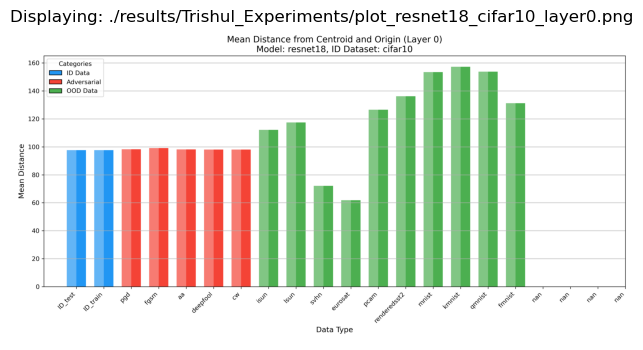

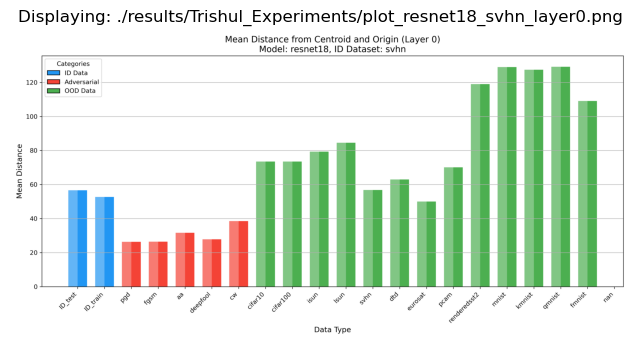

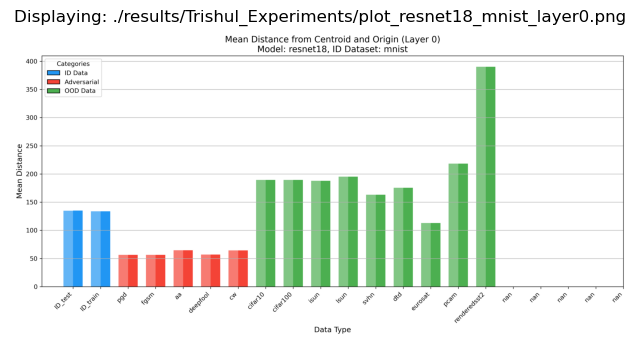

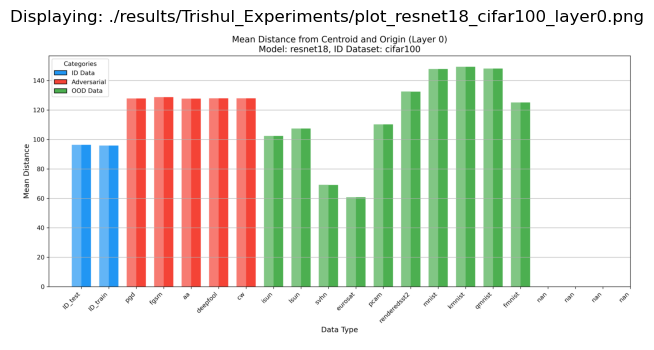

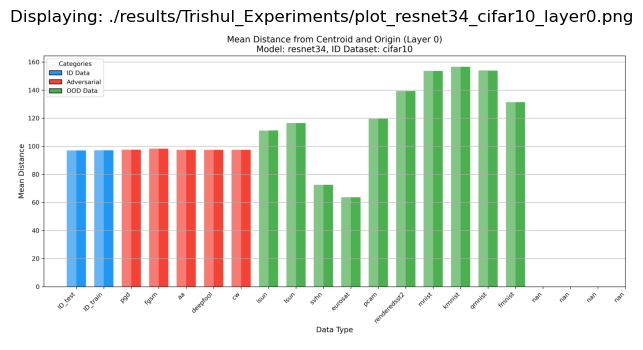

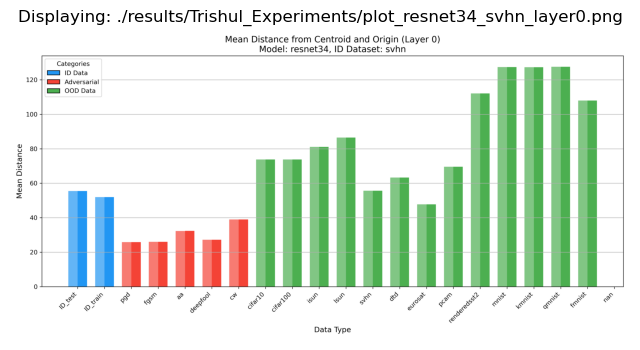

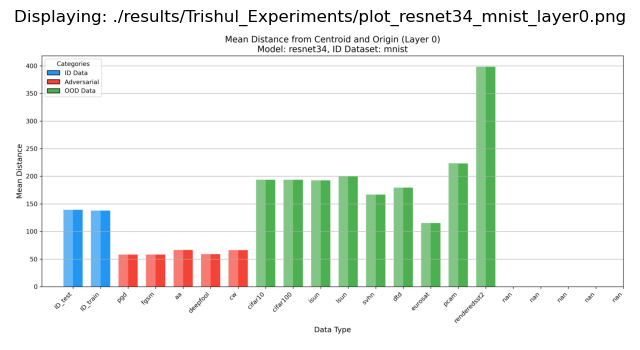

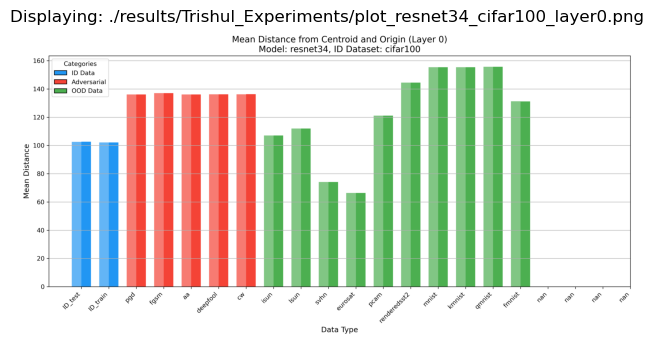

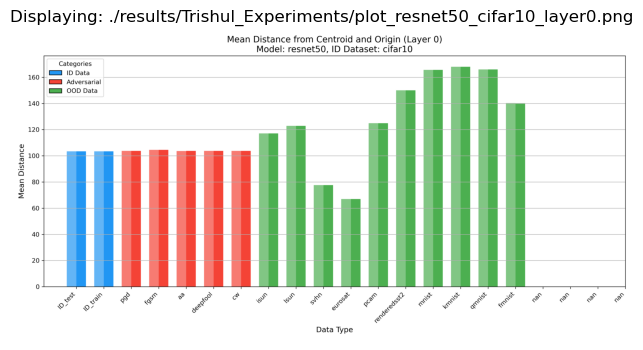

./results/Trishul_Experiments/plot_resnet50_svhn_layer0.png  -> not found!!
./results/Trishul_Experiments/plot_resnet50_mnist_layer0.png  -> not found!!


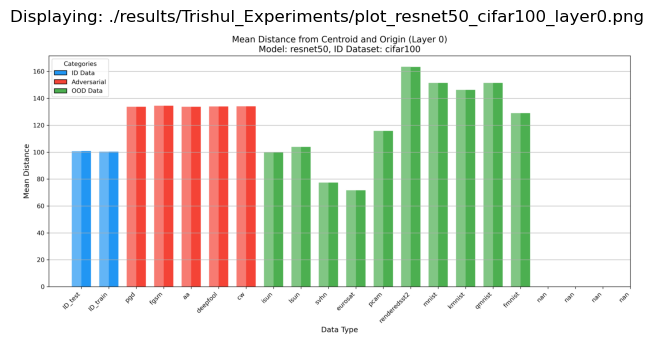

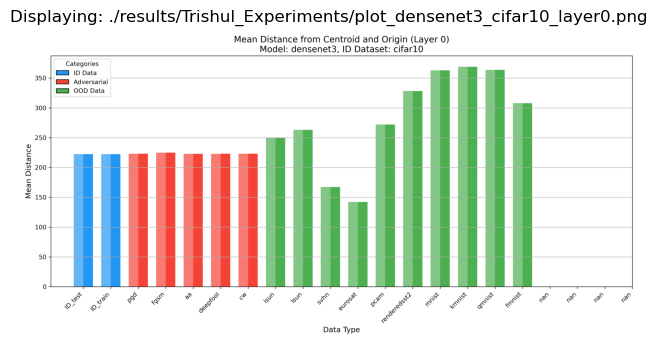

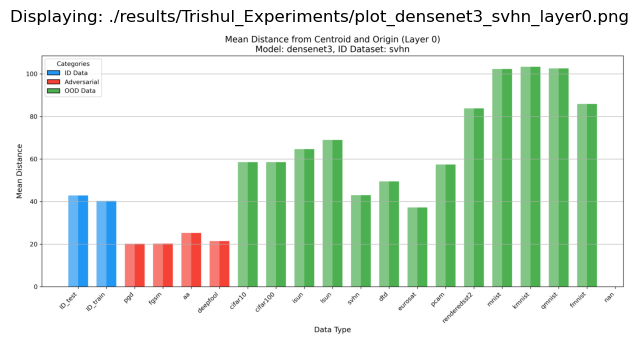

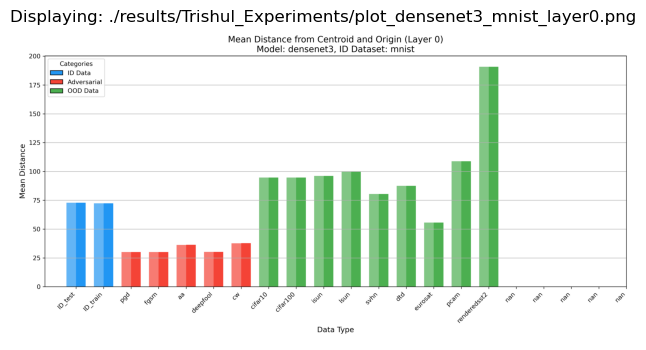

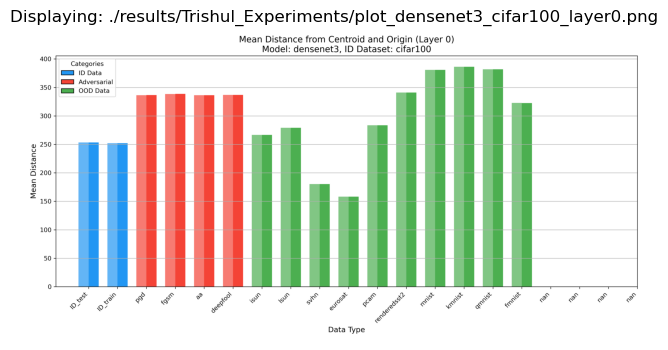

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
models = ["resnet18","resnet34","resnet50","densenet3"]
train_data= ["cifar10","svhn","mnist","cifar100"]
f= 0
for m in models:
    for d in train_data:
        png_file_path = f"./results/Trishul_Experiments/plot_{m}_{d}_layer{f}.png"# <--- IMPORTANT: Change this to your actual file path

        try:
            img = mpimg.imread(png_file_path)
        except:
            print(png_file_path," -> not found!!")
            continue
        # Create a figure and an axes
        plt.figure(figsize=(8, 6)) # Optional: Adjust figure size

        # Display the image
        plt.imshow(img)

        # Optional: Remove axis ticks and labels for a cleaner image display
        plt.axis('off')

        # Add a title (optional)
        plt.title(f'Displaying: {png_file_path}')

        # Show the plot
        plt.show()

# find class means

In [ ]:
# start_time = time.time()

# import torch
# import cupy as cp
# from collections import defaultdict
# import torch.nn.functional as F
# flag = 0
# batch_count = 0

# labels = []
# logits = []
# device = "cuda:0"
# model.eval()
# loaders = train_loader
 
# with torch.no_grad():
#     dummy_input = torch.zeros(1, *next(iter(loaders))[0].shape[1:]).to(device)
#     dummy_features = model.intermediate_forward_all(dummy_input)
    
#     out0,out1,out2,out3,out4,feats,logits = model.intermediate_forward_all(dummy_input)
#     dummy_features = (out0,out1,out2,out3,out4)
#     dummy_features = [f.view(f.size(0), f.size(1), -1) for f in dummy_features]
#     dummy_features = [torch.mean(f, 2) for f in dummy_features] 
 
#     feature_shapes = [f.shape[1] for f in dummy_features]

# class_sums = defaultdict(lambda: [cp.zeros(shape) for shape in feature_shapes])
# class_counts = defaultdict(int)

# with torch.no_grad():
#     for inputs, targets in loaders:
#         inputs = inputs.to(device)
        
#         out0,out1,out2,out3,out4,feats,logits= model.intermediate_forward_all(inputs)
#         f_all = (out0,out1,out2,out3,out4)
       
#         f_all = [f.view(f.size(0), f.size(1), -1) for f in f_all]
#         f_all = [ cp.asarray(torch.mean(f,2)) for f in f_all ]
#         if flag == 0:
#             rolling_sum_f_all =  [cp.zeros(f.shape[1:]) for f in f_all]
#             flag += 1
#         rolling_sum_f_all =  [roll + cp.sum (f,axis =0 ) for roll ,f in zip(rolling_sum_f_all, f_all)]
        
#         rolling_mean_f_all = [sum/batch_count for sum in rolling_sum_f_all]
         
#         for b in range(inputs.shape[0]):
#             label = targets[b].item()
#             class_counts[label] += 1
             
#             for i in range(len(f_all)):
#                 class_sums[label][i] += f_all[i][b]

#         batch_count += inputs.shape[0]
#         labels.extend(targets.cpu().numpy())
 
# class_means = {}
# for label in range(num_classes):
#     class_means[label] = [class_sums[label][i] / class_counts[label] if class_counts[label] > 0 else cp.zeros_like(class_sums[label][i]) for i in range(len(f_all))]



# end_time = time.time()
# print(end_time-start_time)


In [ ]:
# def euclidean_distance(x, y):
#     return cp.linalg.norm(x - y, axis=1)


# def find_closest_Class(features_batch, class_means, layer, device='cpu'):
#     """
#     Vectorized PyTorch version: computes distances between each feature in the batch
#     and all class means at the specified layer.

#     Args:
#         features_batch: list or tensor of shape [batch_size, feature_dim]
#         class_means: dict[label] -> list of means per layer (each mean is a list/tensor)
#         layer: int, index of the layer to use for each class
#         device: 'cpu' or 'cuda'
    
#     Returns:
#         List of lists: each sublist contains class labels sorted by distance
#     """
#     labels = list(class_means.keys())
#     # label_tensor = torch.tensor([int(l) for l in labels], device=device)

#     # Stack the means at the specified layer into one tensor: [num_classes, feature_dim]
#     means_tensor = torch.stack(
#         [torch.tensor(class_means[label][layer], device=device, dtype=torch.float32) for label in labels]
#     )  # [num_classes, feature_dim]

#     # Convert features_batch to a tensor: [batch_size, feature_dim]
#     features_tensor = torch.tensor(features_batch, device=device, dtype=torch.float32)

#     # Compute distances: [batch_size, num_classes]
#     # Using broadcasting: (a - b)^2 summed across features
#     dists = torch.cdist(features_tensor, means_tensor, p=2)  # Euclidean distance

#     # Sort distances for each sample
#     sorted_indices = torch.argsort(dists, dim=1)  # [batch_size, num_classes]

#     # Convert indices to label strings
#     sorted_labels = [[labels[i] for i in row] for row in sorted_indices.cpu().tolist()]

#     return sorted_labels




# # # Function to compute distances for each layer
# # def find_closest_Class(features, class_means, layer):
# #     # given a feature , it finds the distance of this feature wrt all the classes in the layer.
# #     #distances [label] = distance of the feature from the label.
# #     distances = {}
# #     print(len(features))
# #     for label, means in class_means.items():
# #         mean = means[layer]
# #         distances[label] = euclidean_distance(features, mean)
# #     print(distances.keys())
# #     print(len(distances[0]))
# #     print(type(distances))
# #     print(type(distances[0]))
    
# #     for i in range(len(features)):
# #         dist = [distances[label][i] for label in distances.keys()]

# #     # return closest_classes
# #     return closest_classes
# loaders = {
#     "pgd": pgd_test_loader,
#     "fgsm": fgsm_test_loader,
#     "aa":autoattack_test_loader ,
#     "deepfool": deepfool_test_loader,
#     "cw" : cw_test_loader,   
#     "ID_test": test_loader,
 
# }  
# import csv
# with open('./results/closest_Class.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["DataType","True label", "Layer0", "Layer1" , "Layer2", "Layer3", "Layer4","Pred"])
#     with torch.no_grad(): 
#         for item in loaders:
#             loader = loaders[item]
            
#             for inputs, targets in loader:
#                 inputs = inputs.to(device)
#                 targets = targets.to(device)
#                 feats= model.intermediate_forward_all(inputs)
#                 # print(time.time()- temp_time," .. taken for feature extraction ")
#                 # temp_time = time.time()
#                 logits = feats[-1]
#                 _, predicted = torch.max(logits, dim=1)  
#                 maha_feats= feats[:-2]
#                 closest_classes = {}
#                 for i in range(len(maha_feats)):
#                     f= maha_feats[i]
#                     f= f.view(f.size(0), f.size(1), -1)
#                     f = cp.asarray(torch.mean(f,2)) 
#                     if i == 0:
#                         closest_classes[i] = []
#                     closest_classes[i] = find_closest_Class(f,class_means,i)

#                 for i in range(len(inputs)):
#                     row = [item, targets[i]]
#                     row += [closest_classes[i] for i in range(len(maha_feats)) ]
#                     row += [predicted[i]]
#                     print(row)
#                     writer.writerow(row)